In [36]:
# !anaconda3/bin/pip install opencv-python
# !pip install pillow
# !pip install scipy
!anaconda3/bin/pip install arcgis

/bin/bash: anaconda3/bin/pip: No such file or directory


In [93]:
import numpy as np
from imageio import imread, imsave
from PIL import Image

import os
from os import listdir

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from collections import Counter

import cv2

import matplotlib.pyplot as plt

## Import Data

In [94]:
ims2017 = []
ims2019 = []
labels = []
gray = False

for image in os.listdir("mdd_proj/time1"):
    im_path = os.path.join("mdd_proj/time1", image)
    im = imread(im_path, as_gray=gray)
    ims2017.append(im)
for image in os.listdir("mdd_proj/time2"):
    im_path = os.path.join("mdd_proj/time2", image)
    im = imread(im_path, as_gray=gray)
    ims2019.append(im)
for image in os.listdir("mdd_proj/label"):
    im_path = os.path.join("mdd_proj/label", image)
    im = imread(im_path, as_gray=gray)
    labels.append(im)

/var/folders/bn/089n4s3x68v0q7tjlp1nlq100000gn/T/ipykernel_55120/2292988431.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(im_path, as_gray=gray)
/var/folders/bn/089n4s3x68v0q7tjlp1nlq100000gn/T/ipykernel_55120/2292988431.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(im_path, as_gray=gray)
/var/folders/bn/089n4s3x68v0q7tjlp1nlq100000gn/T/ipykernel_55120/2292988431.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use 

## Simple feature extraction
Creating a difference image of less resolution, using only the green color channel

In [169]:
def mean_pooling(im, pooling_size=[5,5]):
    M, N = im.shape
    W, H = pooling_size
    
    MH = M // H
    NW = N // W
    pooled_im = im[:MH*H, :NW*W].reshape(MH, H, NW, W).mean(axis=(1, 3))
    return pooled_im

def diff_blue_pooled(im1, im2):
    diff = im1 - im2
    diff_blue = diff[:,:,1].reshape(diff.shape[0:2])
    pooled_diff = mean_pooling(diff_blue)
    size = np.asarray(pooled_diff.shape)
    return size, pooled_diff
    

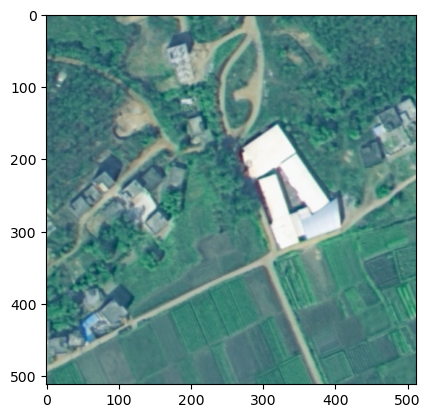

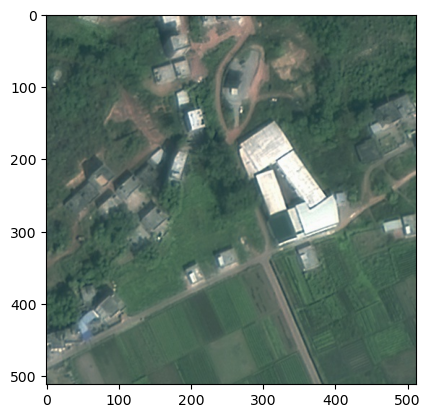

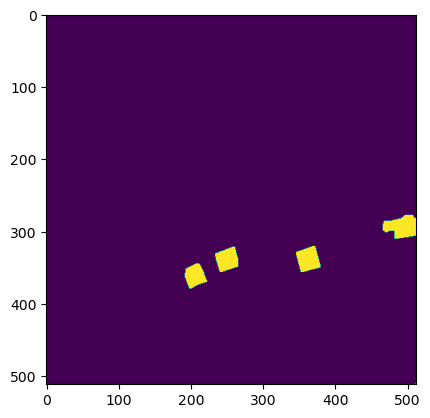

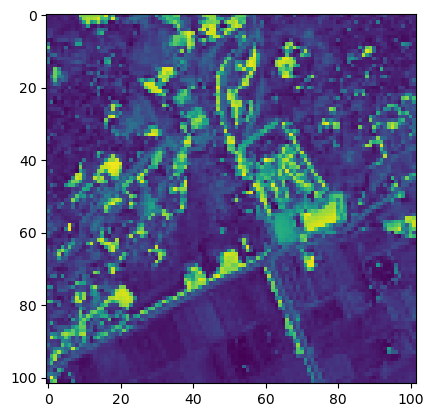

[102 102]


In [171]:
ind = 5
im1, im2, label = ims2017[ind], ims2019[ind], labels[ind]
size, diff_blue = diff_blue_pooled(im1, im2)

debug = True #change to False if you don't want to see the debug images
if debug == True:
    plt.imshow(im1)
    plt.show()
    plt.imshow(im2)
    plt.show()
    plt.imshow(label)
    plt.show()

    plt.imshow(diff_blue)
    plt.show()

    print(size)

In [78]:
# save difference images for potential easy import later
count = 0
for i in range(len(ims2017)):
    size, diff = diff_blue_pooled(ims2017[i], ims2019[i])
    cv2.imwrite("mdd_proj/diff_ims/"+"diff_im"+str(count)+'.png',diff)
    lab_p = mean_pooling(labels[i])
    cv2.imwrite("mdd_proj/labels_s/"+"label"+str(count)+'.png',lab_p)
    count +=1

## Classifying

In [31]:
#Imports for tried classifiers
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sklearn.tree, sklearn.ensemble
import tensorflow.python.keras.utils
import random

import os

In [172]:
# get difference images and labels from downloaded folders
diff_ims = []
labelss = []
gray = True

for image in os.listdir("mdd_proj/labels_s"):
    im_path = os.path.join("mdd_proj/labels_s", image)
    im = imread(im_path, as_gray=gray)
    diff_ims.append(im)
for image in os.listdir("mdd_proj/diff_ims"):
    im_path = os.path.join("mdd_proj/diff_ims", image)
    lab = imread(im_path, as_gray=gray)
    labelss.append(im)

/var/folders/bn/089n4s3x68v0q7tjlp1nlq100000gn/T/ipykernel_55120/4195634073.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(im_path, as_gray=gray)


ValueError: Could not find a backend to open `mdd_proj/labels_s/.DS_Store`` with iomode `ri`.

In [103]:
# OR get difference images already in lists
diff_ims = []
labels_p = []
count = 0
for i in range(len(ims2017)):
    size, diff = diff_blue_pooled(ims2017[i], ims2019[i])
    diff_ims.append(diff)
    lab_p = mean_pooling(labels[i])
    labels_p.append(lab_p)

### Preprocess X and Y for classifying

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_x_y(x, y):
    for i, im in enumerate(x):
        x[i] = np.array(im).flatten()
        x[i] = np.ndarray.tolist(x[i])
    X = np.array(x)
    for i, lab in enumerate(y):
        y[i] = np.array(lab).flatten()
        y[i] = np.ndarray.tolist(y[i])
    Y = np.array(y)
    return X, Y

X, Y = preprocess_x_y(diff_ims, labels_p)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (252, 10404)
X_test Shape: (108, 10404)
y_train Shape: (252, 10404)
y_test Shape:(108, 10404)


### Neural Network Classificiation try

In [156]:
#do one hot encoding
y_train_one_hot = (keras.utils.to_categorical(y_train)).astype(np.uint8)
y_test_one_hot = (keras.utils.to_categorical(y_test)).astype(np.uint8)

In [159]:
def config_layers(X_train, NNH_1, NNH_2, y_train):
    num_input_units = X_train.shape[1] # Input size of X_train
    num_logits = y_train.shape[1] # size of logits
    return num_input_units, NNH_1, NNH_2, num_logits

# Define the layers
NNH_1 = 200 #Number of neurons, hidden layer 1
NNH_2 = 80 #Number of neurons, potential hidden layer 2
NNH_3 = 60
num_input_units, NNH_1, NNH_2, num_logits = config_layers(X_train, NNH_1, NNH_2, y_train_one_hot)

#Design Neural Network
image_model = keras.models.Sequential()
image_model.add(Dense(NNH_1, input_dim=num_input_units, activation='relu'))
image_model.add(Dense(NNH_2, input_dim=NNH_1, activation='relu'))
image_model.add(Dense(NNH_3, input_dim=NNH_3, activation='relu'))
image_model.add(Dense(num_logits, activation='softmax'))

In [160]:
# compile the keras model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
image_model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
# Print NN-model summary
print(image_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               2081000   
_________________________________________________________________
dense_9 (Dense)              (None, 80)                16080     
_________________________________________________________________
dense_10 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_11 (Dense)             (None, 10404)             634644    
Total params: 2,736,584
Trainable params: 2,736,584
Non-trainable params: 0
_________________________________________________________________
None


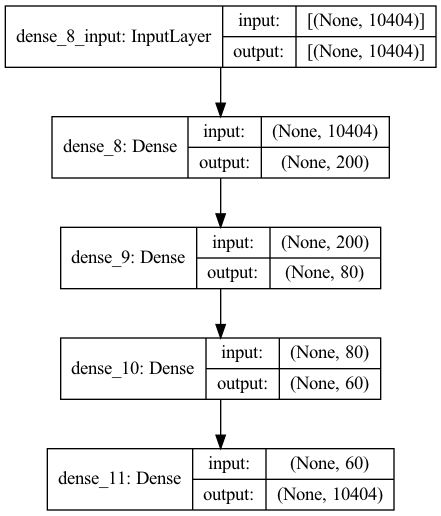

In [162]:
# Plot NN-model
keras.utils.plot_model(image_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [163]:
checkpoint_path = "learned_weights/weights.best.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='auto',
                                save_best_only=True, save_weights_only=False, save_freq='epoch', verbose=1)

In [164]:
#Train the model!
validation_split = 0.3
epochs = 30
batch_size = 10

history = image_model.fit(X_train, y_train, validation_split=validation_split,\
                    epochs=epochs, batch_size=batch_size, callbacks = [cp_callback])

Epoch 1/30
18/18 [==============================] - 1s 24ms/step - loss: -6410.2812 - accuracy: 0.0000e+00 - val_loss: -32626.1484 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to learned_weights/weights.best.hdf5
Epoch 2/30
18/18 [==============================] - 0s 16ms/step - loss: -176875.2344 - accuracy: 0.0000e+00 - val_loss: -593887.0625 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/30
18/18 [==============================] - 0s 17ms/step - loss: -1750208.1250 - accuracy: 0.0000e+00 - val_loss: -4214108.5000 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/30
18/18 [==============================] - 0s 17ms/step - loss: -10054460.0000 - accuracy: 0.0000e+00 - val_loss: -19265616.0000 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/30
18/18 [==============================] - 0s 18ms/step - loss: -358

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


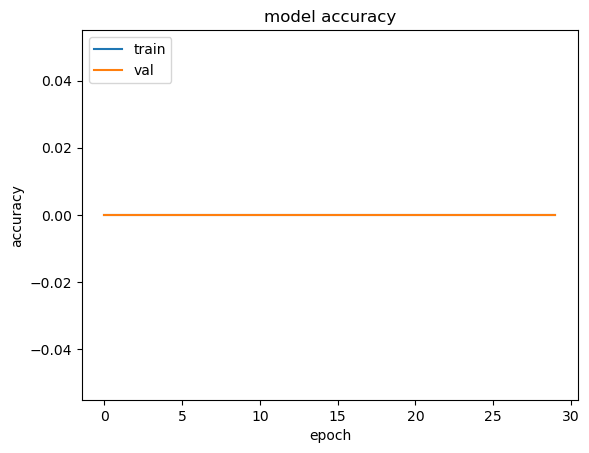

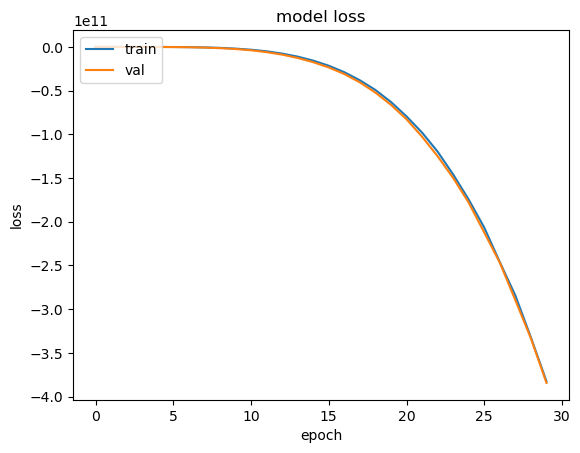

In [165]:
plot_history = True

if plot_history is True:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)
regr.predict(X[[0]])

array([[5.25441834e-07, 5.22176531e-07, 5.22176531e-07, ...,
        8.88083143e-07, 8.88083143e-07, 8.88083143e-07]])

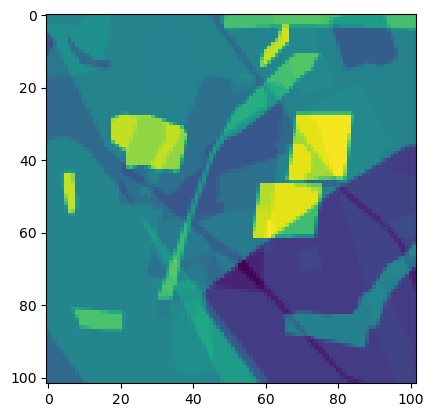

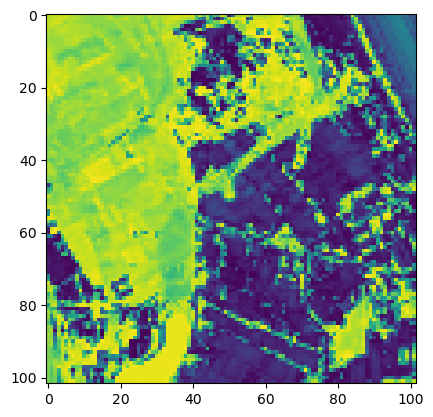

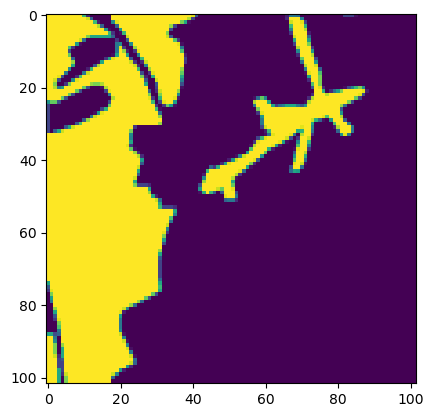

In [131]:
# Predict the labels of test data
# knn_pred = knn.predict(X_test)
regr_pred = regr.predict(X_test)

classifications = regr_pred.reshape(-1, 102, 102)
classification0 = classifications[0]
classification1 = classifications[1]
Xt = X_test.reshape(-1, 102, 102)
Xt0 = Xt[1]
Yt = y_test.reshape(-1, 102, 102)
Yt0 = Yt[1]
plt.imshow(classification1)
plt.show()
plt.imshow(Xt0)
plt.show()
plt.imshow(Yt0)
plt.show()

In [30]:
# Use Random Forest
rf_clf = RandomForestRegressor()
rf_clf.fit(X_train, y_train) #fit model

RandomForestRegressor()

In [32]:
y_pred_rf = rf_clf.predict(X_test) #predict on test data

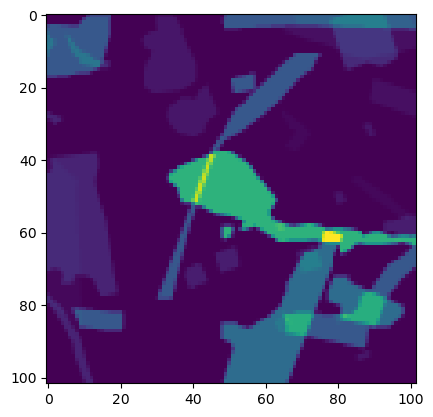

In [173]:
classifications = y_pred_rf.reshape(-1, 102, 102)
classification0 = classifications[0]
plt.imshow(classification0)
plt.show()